In [37]:
# TODO: investigate Unnamed column!

In [38]:
import json
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from scipy.stats.kde import gaussian_kde
import scipy.signal as signal
%matplotlib inline
from IPython.html import widgets
from IPython.html.widgets import interact,fixed
from IPython.display import clear_output

from utils import \
    maybe_get_model,\
    persist_widget_value,\
    snd,\
    from_file,\
    to_file,\
    format_timestamp
    
from scipy.optimize import \
    curve_fit    
    
from toolz import \
    curry,\
    thread_last
    
from collections import \
    OrderedDict

In [39]:
threshold_filepath = '/notebooks/tmp/temp_thresholds.json'
all_thresholds_filepath = '/notebooks/tmp/cell_phase_thresholds.csv'
model_filepath = '/notebooks/tmp/threshold-ui-model.json'
uiget = maybe_get_model(model_filepath) # key -> value
uiset = persist_widget_value(model_filepath) # widget -> key

In [40]:
# String -> String -> Float -> SideEffect[File]
def save_temp_threshold(condition,threshold):
    """ Save threshold (for specific groups) to file.
        This temp file will be updated as the user uses the widgets below. 
        
        This file will then be used to join against the main data and saved. """
    
    data = {'Condition': condition,
            'Threshold': threshold}
    to_file(threshold_filepath,json.dumps(data))

In [41]:
execfile('/notebooks/assay-explorer/src/display_utils.py')

In [42]:
# Read data from primary datastore
data = pd.read_csv('/notebooks/moldev-data/db/db.csv')

In [43]:
# Prepare upload time options to select from
upload_timestamps = sorted(data['Upload Timestamp'].unique().tolist(), reverse = True)
formatted_upload_timestamps = map(format_timestamp,upload_timestamps)
upload_ts_dict = thread_last(
    [formatted_upload_timestamps,upload_timestamps],
    (apply,zip),
    OrderedDict)

In [44]:
selected_upload = widgets.Dropdown(
    options=upload_ts_dict,
    value = uiget('CellPhaseThresholds:UploadTimestamp',upload_timestamps[0]))
uiset(selected_upload,'CellPhaseThresholds:UploadTimestamp')

# Select dataset
Click `Cell > Run All` in the menu above to update the dataset shown.

In [45]:
selected_upload

In [46]:
cells = data[data['Upload Timestamp'] == selected_upload.value]
unselected_data = data[data['Upload Timestamp'] != selected_upload.value]

In [47]:
# [Float] -> Float
def get_threshold(intensity,bw = 0.35):
    """ Given an array of intensities, find the intensity 
        threshold separating the G1 peak from the S/G2 peak. """
    kde_fit = gaussian_kde(intensity,bw)
    x = np.linspace(min(intensity),
                    max(intensity),
                    1000)
    y = kde_fit(x)
    ddx = np.diff(np.diff(y)) # second derivative of fit
    peak = np.argmin(ddx) # most frequent intensity 
    index = min([yi for yi in signal.argrelmax(ddx)[0] if yi > peak])
    threshold = x[index]
    return threshold

In [48]:
# Float -> Float -> Float -> Float -> Float
def gaussian(x,a,m,sd):
    """ Return value of gaussian at value x for 
        given amplitude, mean, and standard deviation. """
    return a * np.exp(-((x-m)**2.0)/(2.0*sd**2.0))

In [49]:
def constrained_double_gaussian(x,a1,m1,sd1,a2,sd2):
    """ Return value of x at for two summed gaussians. 
        The second gaussian has a mean twice that of the first. """
    g1 = gaussian(x,a1,m1,sd1)
    g2 = gaussian(x,a2,2.0*m1,sd2)
    return g1 + g2

In [50]:
# x = np.arange(-10,10,0.05)
# y = (lambda xi: gaussian(0.5,-5,np.sqrt(0.3),xi))(x)
# y2 = (lambda xi: constrained_double_gaussian(xi,0.5,1,0.3,0.3,0.3))(x)
# popt = curve_fit(constrained_double_gaussian,x,y2,[0.5,1,0.3,0.35,0.3])
# popt[0]
# yfit = (lambda xi: constrained_double_gaussian(xi,*popt[0]))(x)
# plt.plot(x,y2)
# plt.plot(x,yfit)

In [51]:
# [Num] -> Float -> SideEffect[Plot]
def plot_gaussian_kde(X,bw,color='k',alpha=1):
    kde_fit = gaussian_kde(X,bw)
    x = np.linspace(min(X),
                    max(X),
                    1000)
    y = kde_fit(x)
    
    # Try fitting double gaussian
#     popt,_ = curve_fit(constrained_double_gaussian,x,y,[4.2e-8,0.2e8,1.0e7,2e-8,1.0e7])
# #     popt,_ = curve_fit(gaussian,x,y,[4.2e-8,0.2e8,1.0e7])
#     yfit = (lambda xi: constrained_double_gaussian(xi,*popt))(x)
#     yfit = (lambda xi: gaussian(xi,*popt))(x)
    
#     print popt
    plt.plot(x,y,color=color,alpha = alpha)
#     plt.plot(x,yfit)

In [52]:
def determine_thresholding_parameters \
(data,display_group,edit_groups,smoothness,manually_set_threshold,show):
    bw = smoothness
    method = show
    intensities = data[data['Condition'] == display_group]['NucIntegrated Intensity_Avg']
    
    plot_gaussian_kde(intensities,bw,color='r')
    plt.title(display_group)
    plt.xlim(0,0.8e8)
    plt.ylim(0,1.5e-7)
    
    # Plot thresholds
    auto_threshold = get_threshold(intensities,bw)
#     threshold_data = pd.read_csv(threshold_filepath)
#     saved_threshold = threshold_data[threshold_data['Condition'] == condition]['Threshold'].values.tolist()[0]
    
    lw = 3
    alpha = 0.3
    
    if method == 'Auto':
        plt.plot(
            [auto_threshold,auto_threshold],
            plt.gca().get_ylim(),
            color = 'r',
            linewidth = lw,
            alpha = alpha,
            label='Auto')
        
        save_temp_threshold(
            edit_groups,
            auto_threshold)
        
        plt.xlabel('NucIntegrated Intensity_Avg (threshold = {})'.format(auto_threshold))
        
    elif method == 'Manual':
        plt.plot(
            [manually_set_threshold,manually_set_threshold],
            plt.gca().get_ylim(),
            color='g',
            linewidth = lw,
            alpha = alpha,
            label='Manual')
        
        save_temp_threshold(
            edit_groups,
            manually_set_threshold)
        
        plt.xlabel('NucIntegrated Intensity_Avg (threshold = {})'.format(manually_set_threshold))
        
    plt.legend()   

# Cell Phase Separation

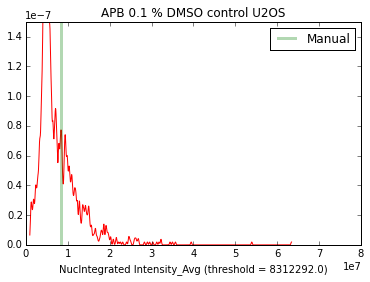

In [53]:
bw = {'min':0.025, 'max': 0.8, 'step':0.025}
intensities = cells['NucIntegrated Intensity_Avg']
thresh = {'min': intensities.min(),
          'max': intensities.max(),
          'step': (intensities.max() - intensities.min())/200,
          'init': intensities.median()}

conditions = cells.sort(['Assay','Cell Type','Contents','Concentration'])['Condition'].unique().tolist()

# Initialize save file with zeros
init_thresholds = pd.DataFrame({'Condition': conditions, 'Threshold': 0})
init_thresholds.to_csv(all_thresholds_filepath, index = False)

interact(
    determine_thresholding_parameters,
    
    data = fixed(cells),
    
    display_group = widgets.Dropdown(
        options = conditions),
    
    edit_groups = widgets.SelectMultiple(
        options = conditions),
    
    smoothness = widgets.FloatSlider(
        min = bw['min'], 
        max = bw['max'], 
        step = bw['step']),
    
    manually_set_threshold = widgets.FloatSlider(
        min = thresh['min'], 
        max = thresh['max'], 
        step = thresh['step'],
        value = thresh['init']),
    
    show = widgets.ToggleButtons(
        options=['Manual','Auto']));


In [54]:
def apply_changes_handler(_):
    """ Grab data from intermediate JSON file. Update CSV with thresholds for all groups. """
    temp_threshold = json.loads(from_file(threshold_filepath))
    all_thresholds = pd.read_csv(all_thresholds_filepath)
    all_thresholds = all_thresholds.set_index('Condition')
    
    conditions = temp_threshold['Condition']
    threshold = temp_threshold['Threshold']
    
    all_thresholds.loc[conditions] = threshold
    all_thresholds = all_thresholds.reset_index()
    all_thresholds.to_csv(all_thresholds_filepath, index=False)
    
    # plot current thresholds
    clear_output()
    all_thresholds.plot(kind = 'bar', x = 'Condition', y = 'Threshold')
    plt.xticks(rotation = 45, ha = 'right')
    plt.gcf().set_size_inches(14, 3)
    plt.title('Current Thresholds')
    
apply_changes_button = widgets.Button(description = 'Apply Changes')    
apply_changes_button.on_click(apply_changes_handler)

Every time you set a threshold for some conditions above, you can apply your changes here. When you're done with everything, click `Save Changes to Database`. (Saving to database takes around 15 seconds...)

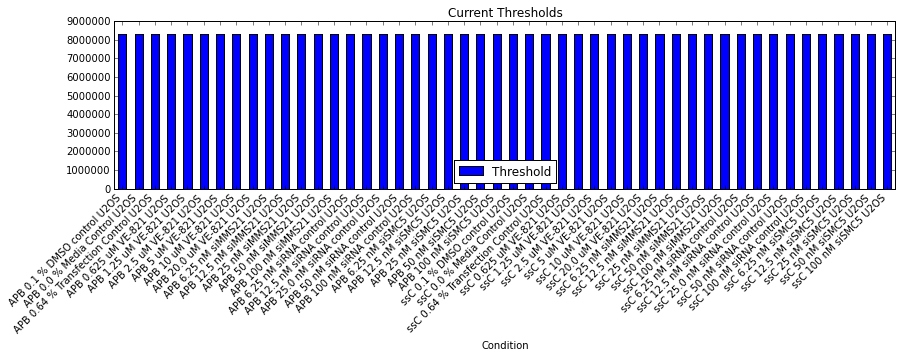

In [55]:
apply_changes_button

In [69]:
def save_to_db_handler(_):
    """ Join thresholds onto data, set phase, and resave database. """
    all_thresholds = pd.read_csv(all_thresholds_filepath)
    
    if 'Threshold' in cells.columns.tolist():
        mycells = cells.drop('Threshold', axis = 1)
    else:
        mycells = cells
    
    if 'Cell Phase' in cells.columns.tolist():
        mycells = mycells.drop('Cell Phase', axis = 1)    
    
    
    updated_cells = pd.merge(mycells, all_thresholds, on = 'Condition')
    
    updated_cells['Cell Phase'] = updated_cells.apply(
        lambda d: 'G1' if d['NucIntegrated Intensity_Avg'] < d['Threshold'] else 'S/G2',
        axis = 1)
    
    whole_db = pd.concat([updated_cells, unselected_data])
    whole_db.to_csv('/notebooks/moldev-data/db/db.csv', index = False)
    
    print "Just saved to database!"

save_to_db_button = widgets.Button(description='Save Changes to Database')    
save_to_db_button.on_click(save_to_db_handler)

In [70]:
save_to_db_button

Just saved to database!


In [58]:
# def save_my_threshold(_):
#     clear_output()
#     save_threshold(threshold_filepath)
#     threshold_data = pd.read_csv(threshold_filepath)
#     threshold_data['Cell Type'] = threshold_data['Condition'].map(lambda x: x.split(' ')[-1]) 
#     threshold_data.sort('Cell Type').plot(kind='bar',x='Condition',y='Threshold')
# #     display(threshold_data.sort('Cell Type')[['Condition','Threshold']])
#     plt.xticks(rotation=45,ha='right')
#     plt.gcf().set_size_inches(8, 3)
#     plt.title('Thresholds for all conditions')
# save_button.on_click(save_my_threshold)


In [59]:
def get_get_cell_phase_counts(data):
    condition = data['Condition'].tolist()[0]
    n_G1 = len(data[data['Cell Phase'] == 'G1'])
    n_G2 = len(data[data['Cell Phase'] == 'S/G2'])
    return {'Condition': condition,
            'Cell Type': condition.split(' ')[-1],
            '# G1 Cells': n_G1,
            '# S/G2 Cells': n_G2,
            'Fraction G1 Cells': float(n_G1) / (n_G1 + n_G2)}

In [60]:
def get_cell_phase_fractions(threshold_filepath,data):
    threshold_data = pd.read_csv(threshold_filepath)
    threshold_data['Cell Type'] = threshold_data['Condition'].map(lambda x: x.split(' ')[-1]) 
    threshold_data = threshold_data.sort('Cell Type')
    new_data = pd.merge(data,threshold_data,on='Condition')
    new_data['Cell Phase'] = new_data.apply(
        lambda d: 'G1' if d['NucIntegrated Intensity_Avg'] < d['Threshold'] else 'S/G2',
        axis = 1)
    condition_groups = new_data.groupby('Condition')
    return thread_first(
        new_data.groupby('Condition'),
        map(snd),
        map(get_get_cell_phase_counts),
        pd.DataFrame)

In [61]:
def plot_cell_phase_fractions(threshold_filepath,data):
    fractions = get_cell_phase_fractions(threshold_filepath,data)
    fractions.sort('Cell Type').plot(kind = 'bar', x = 'Condition', y = 'Fraction G1 Cells')
    plt.xticks(rotation=45,ha='right')
    plt.gcf().set_size_inches(8, 3)
    plt.title('Cell Phase Fractions')

In [62]:
# plot_cell_phase_fractions(threshold_filepath,cells);